# imports and data

In [1]:
data_dir = '/home/ubuntu/data/iceberg'

import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation
from keras.optimizers import Adam
import cv2
import keras
import os
from keras.callbacks import TensorBoard

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.layers.merge import Add, Concatenate

from PIL import Image

import keras
print(keras.__version__)

Using TensorFlow backend.


2.1.1


In [21]:
vgg_base = VGG16(weights='imagenet', include_top=False)

In [22]:
vgg_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [24]:
def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

In [108]:
# convert images to linear and do the processing for imagenet 

In [8]:
np.random.seed(1234)
from scipy.misc import imresize
from skimage.transform import resize

def get_scaled_imgs(df):
    imgs = []

    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.power(10, np.array(row['band_1']).reshape(75, 75)/10)
        band_2 = np.power(10, np.array(row['band_2']).reshape(75, 75)/10)
        band_3 = (band_1 + band_2)/2 # plus since log(x*y) = log(x) + log(y)

#         band_1 = np.array(row['band_1']).reshape(75, 75)
#         band_2 = np.array(row['band_2']).reshape(75, 75)
#         band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        band_1 *= (255.0/band_1.max())
        band_2 *= (255.0/band_2.max())
        band_3 *= (255.0/band_3.max())

        img = resize(np.dstack((band_1, band_2, band_3)), (224, 224), mode='constant')
        imgs.append(img)

    return np.array(imgs)

def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

In [9]:
df_train = pd.read_json(os.path.join(data_dir, 'train.json'))
Xtrain = get_scaled_imgs(df_train)
Ytrain = np.array(df_train['is_iceberg'])

df_train.inc_angle = df_train.inc_angle.replace('na',0)
idx_tr = np.where(df_train.inc_angle>0)

Ytrain = Ytrain[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]
Xinc = df_train.inc_angle[idx_tr[0]]


In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_img_set(img_num):
    # randomly needs the squeeze false parameter if you only want one row of images
    f,ax = plt.subplots(1,3,figsize=(20,10), squeeze=False)
    ax[0][0].imshow(Xtrain[img_num, :, :,0]), ax[0][0].set_title("band 1")
    ax[0][1].imshow(Xtrain[img_num, :, :,1]), ax[0][1].set_title("band 2")
    ax[0][2].imshow(Xtrain[img_num, :, :,2]), ax[0][2].set_title("avg band1,2")
 

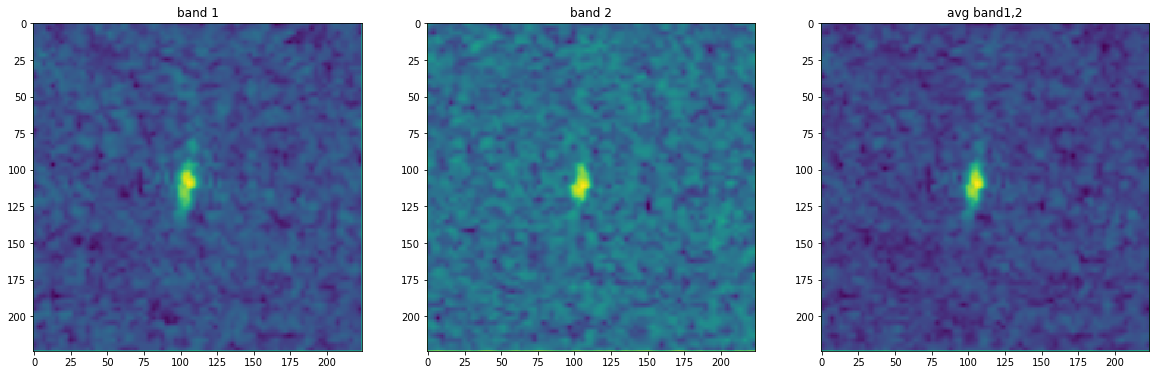

In [58]:
img_num = 0
plot_img_set(img_num)

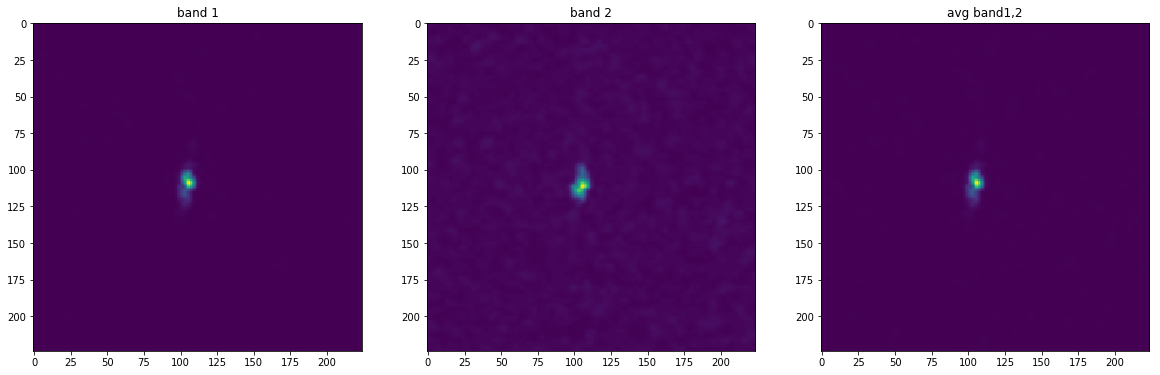

In [54]:
img_num = 0
plot_img_set(img_num)

In [12]:
Xtrain.shape, Xinc.shape, Ytrain.shape

((1471, 224, 224, 3), (1471,), (1471,))

In [13]:
Xvalid = Xtrain[0:300]
Xinc_valid = Xinc[0:300]
Yvalid = Ytrain[0:300]

Xtrain_train = Xtrain[300:1471]
Xinc_train = Xinc[300:1471]
Ytrain_train = Ytrain[300:1471]

In [14]:
# remove all 3 below if you just want orginal data
Xtrain_train = get_more_images(Xtrain_train)
Xinc_train = np.concatenate((Xinc_train,Xinc_train,Xinc_train))
Ytrain_train = np.concatenate((Ytrain_train,Ytrain_train,Ytrain_train))

In [15]:
Xtrain_train.shape, Xinc_train.shape, Ytrain_train.shape

((3513, 224, 224, 3), (3513,), (3513,))

In [16]:
Xvalid.shape, Xinc_valid.shape, Yvalid.shape

((300, 224, 224, 3), (300,), (300,))

In [17]:
Yvalid[Yvalid == 0].shape, Yvalid[Yvalid == 1].shape

((144,), (156,))

In [93]:
test = preprocess_input(Xtrain_train)

In [94]:
test[1][:,:,2].max(), Xtrain_train[1][:,:,2].max()

(111.01833378241821, 129.80861244408564)

In [18]:
Xtrain_train = preprocess_input(Xtrain_train)
Xvalid = preprocess_input(Xvalid)
Xtrain_imagenet = preprocess_input(Xtrain)

In [19]:
def create_precomputed_data(model, data, data_labels):
    conv_features = model.predict(data)
    labels_onehot = to_categorical(data_labels)
    labels = data_labels
    return (conv_features, labels_onehot, labels)

In [23]:
trn_conv_features, trn_labels, trn_labels_1 = create_precomputed_data(vgg_base, Xtrain_train, Ytrain_train)
val_conv_features, val_labels, val_labels_1 = create_precomputed_data(vgg_base, Xvalid, Yvalid)
all_conv_features, all_labels, all_labels_1 = create_precomputed_data(vgg_base, Xtrain_imagenet, Ytrain)

In [24]:
trn_conv_features.shape, trn_labels.shape, val_conv_features.shape, val_labels.shape

((3513, 7, 7, 512), (3513, 2), (300, 7, 7, 512), (300, 2))

In [25]:
assert trn_conv_features.shape == (3513, 7, 7, 512), "trn_conv_features not as expected"
assert trn_labels.shape == (3513, 2), "trn_labels not as expected"

assert val_conv_features.shape == (300, 7, 7, 512), "val_conv_features not as expected"
assert val_labels.shape == (300, 2), "val_labels not as expected"

In [26]:
classifier_input_shape = (7, 7, 512)
classifier_input = Input(shape=classifier_input_shape)

# deeper model with inc angle 

In [27]:
batch_size = 256
        
tbCallBack = TensorBoard(log_dir='/home/ubuntu/data/tensorboardlogs/', histogram_freq=0, write_graph=True, write_images=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, epsilon=1e-4, mode='min')

In [33]:
inc_angle_input = Input(shape=(1,))

nf = 128
p = 0.5

x = Conv2D(nf,(3,3), activation='relu', padding='same')(classifier_input)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D()(x)
x = Dropout(p)(x)
x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=1)(x)
x = MaxPooling2D()(x)
x = Dropout(p)(x)
x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(p)(x)
x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(p)(x)
x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=1)(x)

# x = MaxPooling2D((1,2))(x)
x = Dropout(p)(x)
x = Conv2D(2,(3,3), padding='same')(x)

# x = GlobalAveragePooling2D()(x)
# x = Activation('softmax')(x)


x = Flatten()(x)

# x = GlobalAveragePooling2D()(x)
m = Concatenate()([inc_angle_input, x])
m = Dense(512, activation='relu')(m)
m = Dense(256, activation='relu')(m)
out = Dense(2, activation='sigmoid')(m)
# out = Activation('softmax')(m)

optimizer = Adam(lr=0.001, decay=0.0)
model_inc_angle = Model(inputs=[classifier_input, inc_angle_input], outputs=out)
model_inc_angle.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
# model_inc_angle.fit([trn_conv_features, Xinc], trn_labels, batch_size=batch_size, epochs=50, verbose=1,shuffle=True,
#           callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tbCallBack], validation_split=0.25)


model_inc_angle.fit([trn_conv_features, Xinc_train], trn_labels,
                                          batch_size=128, 
                                          epochs=50,
                                          validation_data=([val_conv_features, Xinc_valid], val_labels),
                                          shuffle=True, 
                                          callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tbCallBack])

Train on 3513 samples, validate on 300 samples
Epoch 1/50
3513/3513 [==============================] - 5s 1ms/step - loss: 0.1113 - acc: 0.9611 - val_loss: 0.8826 - val_acc: 0.7800
Epoch 2/50
3513/3513 [==============================] - 5s 1ms/step - loss: 0.0948 - acc: 0.9688 - val_loss: 0.9195 - val_acc: 0.7767
Epoch 3/50
3513/3513 [==============================] - 5s 1ms/step - loss: 0.0892 - acc: 0.9684 - val_loss: 0.9008 - val_acc: 0.7833
Epoch 4/50
3513/3513 [==============================] - 5s 1ms/step - loss: 0.0919 - acc: 0.9694 - val_loss: 0.9728 - val_acc: 0.7700
Epoch 5/50
3513/3513 [==============================] - 5s 1ms/step - loss: 0.0732 - acc: 0.9741 - val_loss: 1.0545 - val_acc: 0.7600
Epoch 6/50
3513/3513 [==============================] - 5s 1ms/step - loss: 0.0728 - acc: 0.9761 - val_loss: 0.9997 - val_acc: 0.7733
Epoch 7/50
3513/3513 [==============================] - 5s 1ms/step - loss: 0.0649 - acc: 0.9765 - val_loss: 1.0634 - val_acc: 0.7667
Epoch 8/50
3513

In [114]:
# model.load_weights(filepath = '.mdl_wts.hdf5')
score = model_inc_angle.evaluate([all_conv_features, Xinc], all_labels, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

1471/1471 [==============================] - 2s 1ms/step
Train score: 0.817565000803
Train accuracy: 0.839564921255


In [4]:
# take out the generated images by filtering out the images without 4 dp in inc angle

data_dir = '/home/ubuntu/data/iceberg'

df_test = pd.read_json(os.path.join(data_dir, 'test.json'))
df_test.inc_angle = df_test.inc_angle.replace('na',0)
df_real = df_test.loc[df_test.inc_angle == round(df_test.inc_angle, 4)]
Xtest_real = (get_scaled_imgs(df_real))
Xtest_inc_real = df_real.inc_angle


In [6]:
Xtest_real.shape, Xtest_inc_real.shape

((3412, 224, 224, 3), (3412,))

In [140]:
test_conv_features = vgg_base.predict(preprocess_input(Xtest_real))

In [141]:
pred_test = model_inc_angle.predict([test_conv_features, Xtest_inc_real])

In [142]:
pred_test[1,1]

0.99917597

In [131]:
Xtest_inc[2]

37.505433159356684

In [143]:
idx_pred_1 = (np.where(pred_test[:,0]>0.95))
idx_pred_0 = (np.where(pred_test[:,0]<0.05))

In [144]:
idx_pred_1[0].shape, idx_pred_0[0].shape

((926,), (2181,))

In [7]:
Xtest_inc_real[idx_pred_1[0],...]

NameError: name 'idx_pred_1' is not defined

In [154]:
Xtrain_pl = np.concatenate((Xtrain_train, preprocess_input(Xtest_real[idx_pred_1[0],...]), preprocess_input(Xtest_real[idx_pred_0[0],...])))
Ytrain_pl = np.concatenate((Ytrain_train, np.ones(idx_pred_1[0].shape[0]), np.zeros(idx_pred_0[0].shape[0])))
# Xinc_pl = np.concatenate((Xinc_train, Xtest_inc_real[idx_pred_1[0],...], Xtest_inc_real[idx_pred_0[0],...]))

MemoryError: 

In [148]:
Xtrain_pl.shape, Ytrain_pl.shape

((6620, 224, 224, 3), (6620,))

In [92]:
# this is the right way round
submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test[:,1].reshape((pred_test[:,1].shape[0]))})
print(submission.head(10))

submission.to_csv('cnn_train_' + str(np.around(score[1], decimals=2))  + '.csv', index=False)

         id    is_iceberg
0  5941774d  3.952795e-01
1  4023181e  9.995781e-01
2  b20200e4  9.970840e-01
3  e7f018bb  9.993762e-01
4  4371c8c3  9.994198e-01
5  a8d9b1fd  9.996321e-01
6  29e7727e  1.797852e-32
7  92a51ffb  9.995446e-01
8  c769ac97  1.552835e-15
9  aee0547d  1.769691e-29


In [93]:
os.getcwd()


'/home/ubuntu/git/learningWithKaggle/ice'

In [94]:
np.around(score[1])

1.0

In [32]:
Yvalid[Yvalid==0].shape, Yvalid[Yvalid==1].shape

((144,), (156,))

In [58]:
classifier_model_v3.fit(trn_conv_features, trn_labels,
                                          batch_size=32, 
                                          epochs=50,
                                          validation_data=(val_conv_features, val_labels),
                                          shuffle=True, 
                                          callbacks=[tbCallBack])

Train on 3713 samples, validate on 700 samples
Epoch 1/50
3713/3713 [==============================] - 11s 3ms/step - loss: 0.5313 - acc: 0.7498 - val_loss: 0.7826 - val_acc: 0.6957
Epoch 2/50
3713/3713 [==============================] - 11s 3ms/step - loss: 0.3282 - acc: 0.8529 - val_loss: 0.4505 - val_acc: 0.8071
Epoch 3/50
3713/3713 [==============================] - 11s 3ms/step - loss: 0.2591 - acc: 0.8942 - val_loss: 0.2983 - val_acc: 0.8800
Epoch 4/50
3713/3713 [==============================] - 11s 3ms/step - loss: 0.2205 - acc: 0.9076 - val_loss: 0.4919 - val_acc: 0.7986
Epoch 5/50
3713/3713 [==============================] - 11s 3ms/step - loss: 0.1512 - acc: 0.9405 - val_loss: 1.0548 - val_acc: 0.6986
Epoch 6/50
3713/3713 [==============================] - 11s 3ms/step - loss: 0.1279 - acc: 0.9534 - val_loss: 0.4099 - val_acc: 0.8771
Epoch 7/50
3713/3713 [==============================] - 11s 3ms/step - loss: 0.0948 - acc: 0.9623 - val_loss: 0.4143 - val_acc: 0.8600
Epoch 8/

In [ ]:
# create pngs of the training and validation data from above - training has aug already. 

In [ ]:
icebergs = train[ train.is_iceberg == 1 ]
ships = train[ train.is_iceberg == 0 ]